
## Part 1 — Setup & Introduction

This notebook implements *Q-Learning* and *Deep Q-Learning* on the **Taxi-v3** environment using **Gymnasium** and **PyTorch**.  
- Implement tabular Q-Learning
- Run hyperparameter experiments (α and ε)
- Implement a DQN (with experience replay)
- Compare Q-Learning and DQN and produce required metrics and plots

In [1]:
#Install necessary packages
%pip install --upgrade pip
%pip install gymnasium tqdm matplotlib pandas numpy

%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/951.1 kB ? eta -:--:--
   ---------------------------------------- 951.1/951.1 kB 22.2 MB/s  0:00:00

   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]
   -------------------------- ------------- 2/3 [gymnasium]


In [2]:
# Imports and basic environment checks
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import gymnasium as gym

# create results directory
os.makedirs("results_taxi", exist_ok=True)

# quick check: Taxi environment
env = gym.make("Taxi-v3")
print("Gymnasium version:", gym.__version__)
print("State space size (should be 500):", env.observation_space.n)
print("Action space size (should be 6):", env.action_space.n)

# close the quick env
env.close()


Gymnasium version: 1.2.1
State space size (should be 500): 500
Action space size (should be 6): 6



Starting quick Q-learning (100 episodes)...
Done.

Sample of rewards (first 10): [-551, -605, -551, -542, -533, -362, -578, -479, -461, -326]
Avg reward (last 20): -278.4
Avg steps (last 20): 185.25


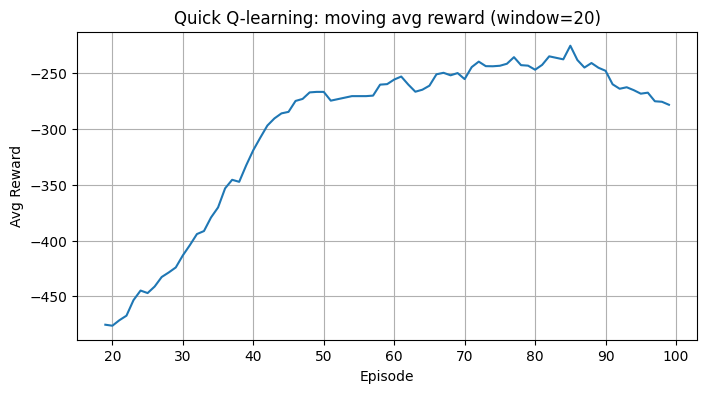

In [3]:

# Minimal Q-learning that runs 100 episodes and prints results
def quick_q_learning(alpha=0.1, epsilon=0.1, gamma=0.9, episodes=100, max_steps=200, seed=42):
    env = gym.make("Taxi-v3")
    np.random.seed(seed)
    env.reset(seed=seed)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    rewards = []
    steps = []
    for ep in range(episodes):
        state, _ = env.reset()
        total = 0
        for t in range(max_steps):
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(Q[state]))
            out = env.step(action)
            if len(out) == 5:
                next_state, reward, terminated, truncated, _ = out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = out
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            state = next_state
            total += reward
            if done:
                break
        rewards.append(total)
        steps.append(t+1)
    env.close()
    return Q, rewards, steps

print("\nStarting quick Q-learning (100 episodes)...")
Q, rewards, steps = quick_q_learning(episodes=100)
print("Done.\n")

print("Sample of rewards (first 10):", rewards[:10])
print("Avg reward (last 20):", np.mean(rewards[-20:]))
print("Avg steps (last 20):", np.mean(steps[-20:]))

# Plot moving average (window=20)
import pandas as pd
ma = pd.Series(rewards).rolling(20).mean()
plt.figure(figsize=(8,4))
plt.plot(ma)
plt.title("Quick Q-learning: moving avg reward (window=20)")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.grid(True)
plt.show()


## Part 2 — Taxi Environment Exploration

Before training the agent, let’s explore the Taxi environment in detail.  
This step helps us understand how each integer state maps to:
- Taxi position (row, column)
- Passenger location
- Destination

We’ll also simulate a few random moves to see rewards and transitions.


In [4]:
# Decode Taxi state into components (row, column, passenger location, destination)
def decode_taxi_state(state):
    """
    Decodes the Taxi-v3 environment's integer state into components:
    (taxi_row, taxi_col, passenger_location, destination)
    """
    out = []
    out.append(state // 100)
    state = state % 100
    out.append(state // 20)
    state = state % 20
    out.append(state // 4)
    out.append(state % 4)
    return tuple(out)

# Test decode for a few sample states
for s in [0, 199, 250, 350, 499]:
    print(f"State {s}: {decode_taxi_state(s)}")
# Decode Taxi state into components (row, column, passenger location, destination)
def decode_taxi_state(state):
    """
    Decodes the Taxi-v3 environment's integer state into components:
    (taxi_row, taxi_col, passenger_location, destination)
    """
    out = []
    out.append(state // 100)
    state = state % 100
    out.append(state // 20)
    state = state % 20
    out.append(state // 4)
    out.append(state % 4)
    return tuple(out)

# Test decode for a few sample states
for s in [0, 199, 250, 350, 499]:
    print(f"State {s}: {decode_taxi_state(s)}")


State 0: (0, 0, 0, 0)
State 199: (1, 4, 4, 3)
State 250: (2, 2, 2, 2)
State 350: (3, 2, 2, 2)
State 499: (4, 4, 4, 3)
State 0: (0, 0, 0, 0)
State 199: (1, 4, 4, 3)
State 250: (2, 2, 2, 2)
State 350: (3, 2, 2, 2)
State 499: (4, 4, 4, 3)


In [5]:
import time

env = gym.make("Taxi-v3", render_mode="ansi")
state, _ = env.reset(seed=42)
print("Initial state:", state)
print(env.render())

for t in range(5):
    action = env.action_space.sample()
    next_state, reward, done, _, _ = env.step(action)
    print(f"Step {t+1}: Action={action}, Reward={reward}, Next State={next_state}")
    print(env.render())
    if done:
        break
env.close()


Initial state: 386
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Step 1: Action=1, Reward=-1, Next State=286
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

Step 2: Action=0, Reward=-1, Next State=386
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step 3: Action=0, Reward=-1, Next State=486
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Step 4: Action=3, Reward=-1, Next State=466
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Step 5: Action=5, Reward=-10, Next State=466
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)



### Observations
- There are **500 discrete states** in total, derived from taxi position, passenger, and destination.
- Rewards:
  - `+20` for successful passenger drop-off
  - `-1` per time step
  - `-10` for illegal pickup/drop actions
- This understanding helps us verify the correctness of our Q-Learning policy later.

## Part 3 — Full Q-Learning Training, Metrics & Hyperparameter Experiments

Tasks implemented in this part:
- Full Q-Learning training function (logging episodes, steps, rewards)
- Baseline run: α=0.1, ε=0.1, γ=0.9
- Deliberate parameter changes (separately):
  - Learning Rate α = [0.01, 0.001, 0.2]
  - Exploration Factor ε = [0.2, 0.3]  (we vary epsilon while keeping alpha=0.1)
- Evaluation (greedy policy) and metrics:
  1. Total episodes (per experiment)
  2. Steps per episode (per episode logged)
  3. Average return per episode (per episode logged)
- Save logs to `results_taxi/` and produce plots (reward moving average, steps moving average).

In [6]:
# Part 3 - Utilities: Q-Learning training, evaluation, plotting and saving

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

# Ensure results directory exists
os.makedirs("results_taxi", exist_ok=True)

def train_q_learning(env_name="Taxi-v3",
                     alpha=0.1,
                     epsilon=0.1,
                     gamma=0.9,
                     episodes=2000,
                     max_steps=200,
                     seed=42,
                     verbose=False):
    """
    Train tabular Q-Learning on Taxi-v3.
    Returns:
      Q (np.array): Q-table (states x actions)
      rewards_per_episode (list)
      steps_per_episode (list)
    """
    import gymnasium as gym
    env = gym.make(env_name)
    # reproducibility (best-effort)
    try:
        env.reset(seed=seed)
        env.action_space.seed(seed)
    except Exception:
        pass

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions), dtype=np.float64)

    rewards = []
    steps = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        step_count = 0

        for t in range(max_steps):
            # epsilon-greedy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(Q[state]))

            out = env.step(action)
            # gymnasium returns (obs, reward, terminated, truncated, info)
            if len(out) == 5:
                next_state, reward, terminated, truncated, _ = out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = out

            # Q update
            best_next = np.max(Q[next_state])
            td_target = reward + gamma * best_next
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            total_reward += reward
            state = next_state
            step_count += 1

            if done:
                break

        rewards.append(total_reward)
        steps.append(step_count)

        if verbose and (ep % max(100, episodes//5) == 0):
            print(f"Ep {ep}/{episodes} reward={total_reward} steps={step_count}")

    env.close()
    return Q, rewards, steps

def evaluate_policy(env_name, Q, episodes=100, max_steps=200, seed=0):
    """
    Evaluate a greedy policy derived from Q-table.
    Returns arrays of returns and steps per episode.
    """
    import gymnasium as gym
    env = gym.make(env_name)
    returns = []
    steps = []
    for ep in range(episodes):
        state, _ = env.reset(seed=(seed+ep) if seed is not None else None)
        total = 0
        step_count = 0
        for _ in range(max_steps):
            action = int(np.argmax(Q[state]))
            out = env.step(action)
            if len(out) == 5:
                next_state, reward, terminated, truncated, _ = out
                done = terminated or truncated
            else:
                next_state, reward, done, _ = out
            total += reward
            state = next_state
            step_count += 1
            if done:
                break
        returns.append(total)
        steps.append(step_count)
    env.close()
    return np.array(returns), np.array(steps)

def moving_average(x, window=100):
    import numpy as np
    if len(x) < window:
        return np.convolve(x, np.ones(len(x))/len(x), mode='valid')
    return np.convolve(x, np.ones(window)/window, mode='valid')

def plot_and_save(results_logs, save_dir="results_taxi", window=100):
    """
    results_logs: dict name -> {'train_rewards':list, 'train_steps':list}
    Saves plots to save_dir.
    """
    os.makedirs(save_dir, exist_ok=True)

    # reward moving average plot
    plt.figure(figsize=(10,6))
    for name, logs in results_logs.items():
        ma = moving_average(logs['train_rewards'], window=window)
        plt.plot(np.arange(len(ma)), ma, label=name)
    plt.xlabel('Episode (moving avg window={})'.format(window))
    plt.ylabel('Average Reward')
    plt.title('Training: Moving average Reward per Episode')
    plt.legend()
    plt.grid(True)
    out_path = os.path.join(save_dir, 'rewards_moving_avg.png')
    plt.tight_layout()
    plt.savefig(out_path)
    plt.show()

    # steps moving average plot
    plt.figure(figsize=(10,6))
    for name, logs in results_logs.items():
        ma = moving_average(logs['train_steps'], window=window)
        plt.plot(np.arange(len(ma)), ma, label=name)
    plt.xlabel('Episode (moving avg window={})'.format(window))
    plt.ylabel('Average Steps')
    plt.title('Training: Moving average Steps per Episode')
    plt.legend()
    plt.grid(True)
    out_path2 = os.path.join(save_dir, 'steps_moving_avg.png')
    plt.tight_layout()
    plt.savefig(out_path2)
    plt.show()

    print("Saved plots to:", save_dir)


In [7]:
# Part 3 - Run baseline + experiments (adjust EPISODES for final runs)
EPISODES = 2000   # change to 5000 for final/long runs
MAX_STEPS = 200
SEED = 42

experiments = []  # list of dicts for summary
logs = {}         # store train logs for plotting

# Baseline
name = "baseline_alpha0.1_eps0.1"
print("Running:", name)
Q_base, r_base, s_base = train_q_learning(alpha=0.1, epsilon=0.1, gamma=0.9,
                                          episodes=EPISODES, max_steps=MAX_STEPS, seed=SEED)
ret_eval, steps_eval = evaluate_policy("Taxi-v3", Q_base, episodes=100, max_steps=MAX_STEPS, seed=SEED+1000)
experiments.append({
    'name': name, 'alpha':0.1, 'epsilon':0.1, 'gamma':0.9,
    'train_episodes': EPISODES,
    'mean_train_return': float(np.mean(r_base)),
    'median_train_return': float(np.median(r_base)),
    'last100_mean_train_return': float(np.mean(r_base[-100:])),
    'mean_eval_return_100eps': float(np.mean(ret_eval)),
    'mean_eval_steps_100eps': float(np.mean(steps_eval))
})
logs[name] = {'train_rewards': r_base, 'train_steps': s_base}

# Alpha sweep (separately)
for a in [0.01, 0.001, 0.2]:
    name = f"alpha_{a}"
    print("Running:", name)
    Q, r, s = train_q_learning(alpha=a, epsilon=0.1, gamma=0.9, episodes=EPISODES, max_steps=MAX_STEPS, seed=SEED)
    ret_eval, steps_eval = evaluate_policy("Taxi-v3", Q, episodes=100, max_steps=MAX_STEPS, seed=SEED+1000)
    experiments.append({
        'name': name, 'alpha':a, 'epsilon':0.1, 'gamma':0.9,
        'train_episodes': EPISODES,
        'mean_train_return': float(np.mean(r)),
        'median_train_return': float(np.median(r)),
        'last100_mean_train_return': float(np.mean(r[-100:])),
        'mean_eval_return_100eps': float(np.mean(ret_eval)),
        'mean_eval_steps_100eps': float(np.mean(steps_eval))
    })
    logs[name] = {'train_rewards': r, 'train_steps': s}

# Epsilon sweep (separately) - vary epsilon, keep alpha = 0.1
for e in [0.2, 0.3]:
    name = f"eps_{e}"
    print("Running:", name)
    Q, r, s = train_q_learning(alpha=0.1, epsilon=e, gamma=0.9, episodes=EPISODES, max_steps=MAX_STEPS, seed=SEED)
    ret_eval, steps_eval = evaluate_policy("Taxi-v3", Q, episodes=100, max_steps=MAX_STEPS, seed=SEED+1000)
    experiments.append({
        'name': name, 'alpha':0.1, 'epsilon':e, 'gamma':0.9,
        'train_episodes': EPISODES,
        'mean_train_return': float(np.mean(r)),
        'median_train_return': float(np.median(r)),
        'last100_mean_train_return': float(np.mean(r[-100:])),
        'mean_eval_return_100eps': float(np.mean(ret_eval)),
        'mean_eval_steps_100eps': float(np.mean(steps_eval))
    })
    logs[name] = {'train_rewards': r, 'train_steps': s}

# Save summary CSV
summary_df = pd.DataFrame(experiments)
summary_csv = os.path.join("results_taxi", "summary_qlearning_experiments.csv")
summary_df.to_csv(summary_csv, index=False)
print("\nSaved summary to:", summary_csv)

# Save per-experiment logs as CSVs
for name, vals in logs.items():
    df = pd.DataFrame({'episode': np.arange(1,len(vals['train_rewards'])+1),
                       'reward': vals['train_rewards'],
                       'steps': vals['train_steps']})
    df.to_csv(os.path.join("results_taxi", f"{name}_train_log.csv"), index=False)

print("All experiments finished. Logs saved to results_taxi/")


Running: baseline_alpha0.1_eps0.1
Running: alpha_0.01
Running: alpha_0.001
Running: alpha_0.2
Running: eps_0.2
Running: eps_0.3

Saved summary to: results_taxi\summary_qlearning_experiments.csv
All experiments finished. Logs saved to results_taxi/


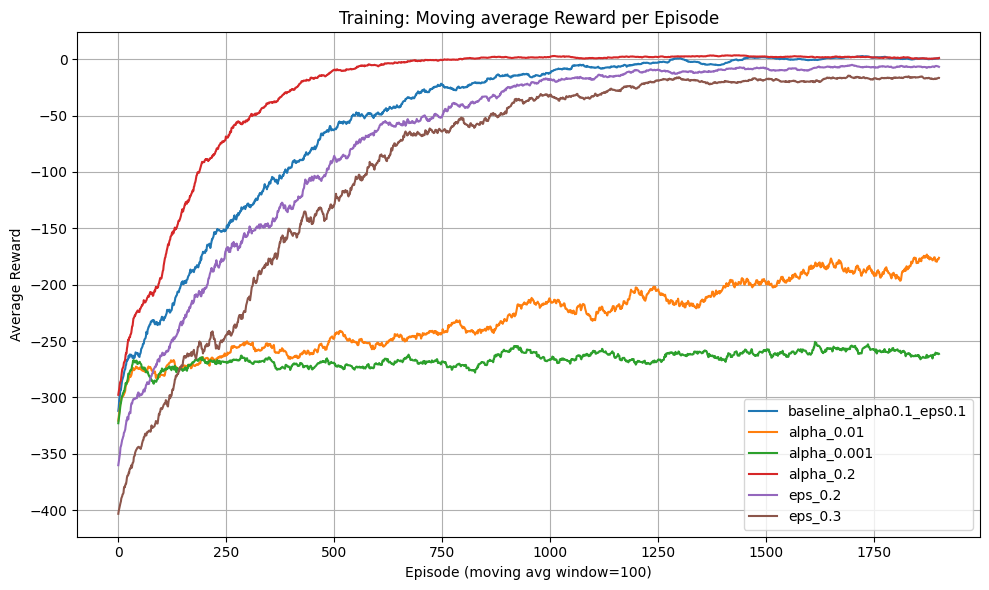

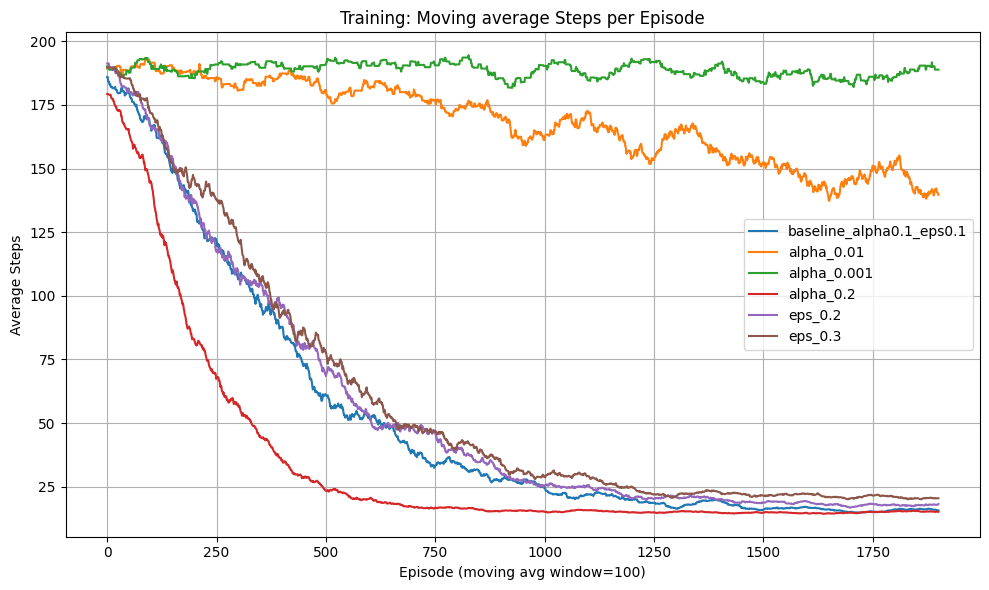

Saved plots to: results_taxi


,name,alpha,epsilon,gamma,train_episodes,mean_train_return,median_train_return,last100_mean_train_return,mean_eval_return_100eps,mean_eval_steps_100eps
0,baseline_alpha0.1_eps0.1,0.100,0.1,0.9,2000,-56.938,-9.0,0.93,-43.06,42.70
1,alpha_0.01,0.010,0.1,0.9,2000,-230.350,-254.0,-176.14,-200.00,200.00
2,alpha_0.001,0.001,0.1,0.9,2000,-268.232,-281.0,-261.42,-235.82,200.00
3,alpha_0.2,0.200,0.1,0.9,2000,-32.882,-0.5,1.14,-2.51,22.46
4,eps_0.2,0.100,0.2,0.9,2000,-74.380,-19.0,-6.72,-37.34,53.72
5,eps_0.3,0.100,0.3,0.9,2000,-96.902,-34.0,-16.52,-37.39,53.77


In [8]:
# Part 3 - Plot training curves from logs dictionary
plot_and_save(logs, save_dir="results_taxi", window=100)

# Display summary table
from IPython.display import display
display(summary_df.round(3))


### Re-run Best Hyperparameter Combination

Now inspect `results_taxi/summary_qlearning_experiments.csv` (displayed above).  
Choose the experiment with the **highest `mean_eval_return_100eps`** (and if tied, lower `mean_eval_steps_100eps`), then re-run a final training with larger episodes (e.g., EPISODES = 5000) using that α and ε.

Example re-run code is provided in the next cell.


In [9]:
# Example: change these values to the best combo you found
BEST_ALPHA = 0.2
BEST_EPSILON = 0.1
FINAL_EPISODES = 5000
FINAL_MAX_STEPS = 200

print(f"Re-running final training: alpha={BEST_ALPHA}, epsilon={BEST_EPSILON}, episodes={FINAL_EPISODES}")
Q_best, r_best, s_best = train_q_learning(alpha=BEST_ALPHA, epsilon=BEST_EPSILON, gamma=0.9,
                                          episodes=FINAL_EPISODES, max_steps=FINAL_MAX_STEPS, seed=SEED)
ret_eval, steps_eval = evaluate_policy("Taxi-v3", Q_best, episodes=200, max_steps=FINAL_MAX_STEPS, seed=SEED+2000)

print("Final run metrics:")
print("Mean train return (last 100):", np.mean(r_best[-100:]))
print("Mean eval return (200 eps):", np.mean(ret_eval))
print("Mean eval steps (200 eps):", np.mean(steps_eval))

# Save final logs
pd.DataFrame({'episode': np.arange(1,len(r_best)+1), 'reward': r_best, 'steps': s_best})\
  .to_csv(os.path.join("results_taxi", f"final_alpha{BEST_ALPHA}_eps{BEST_EPSILON}_train_log.csv"), index=False)


Re-running final training: alpha=0.2, epsilon=0.1, episodes=5000
Final run metrics:
Mean train return (last 100): 1.41
Mean eval return (200 eps): 8.335
Mean eval steps (200 eps): 12.665


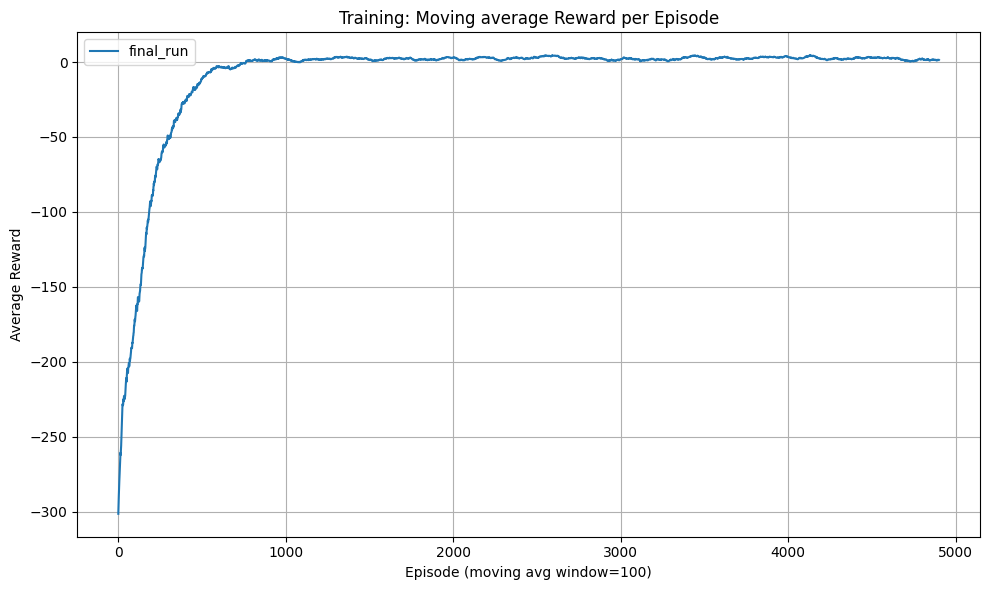

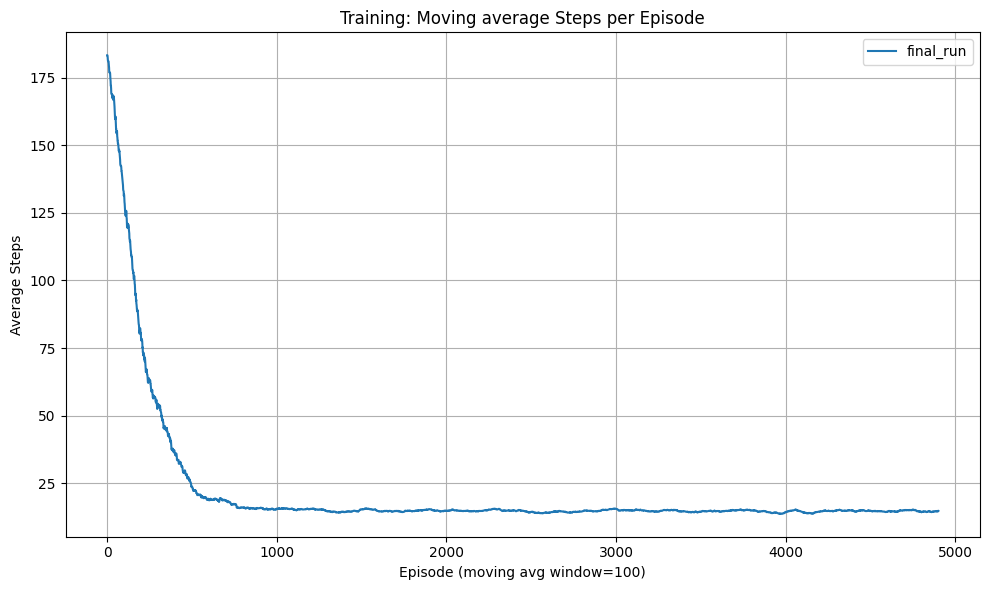

Saved plots to: results_taxi


In [10]:
# Plot final run moving average
plot_and_save({'final_run': {'train_rewards': r_best, 'train_steps': s_best}}, save_dir="results_taxi", window=100)


## Part 4 — Hyperparameter Tuning and Analysis

In this section, we will experiment with different values of **learning rate (α)** and **exploration factor (ε)**  
to analyze their effect on the agent’s learning performance.

**Experiment 1:** Vary learning rate α = [0.01, 0.001, 0.2]  
**Experiment 2:** Vary exploration factor ε = [0.2, 0.3]  
All other parameters remain constant (γ = 0.9, episodes = 1000).

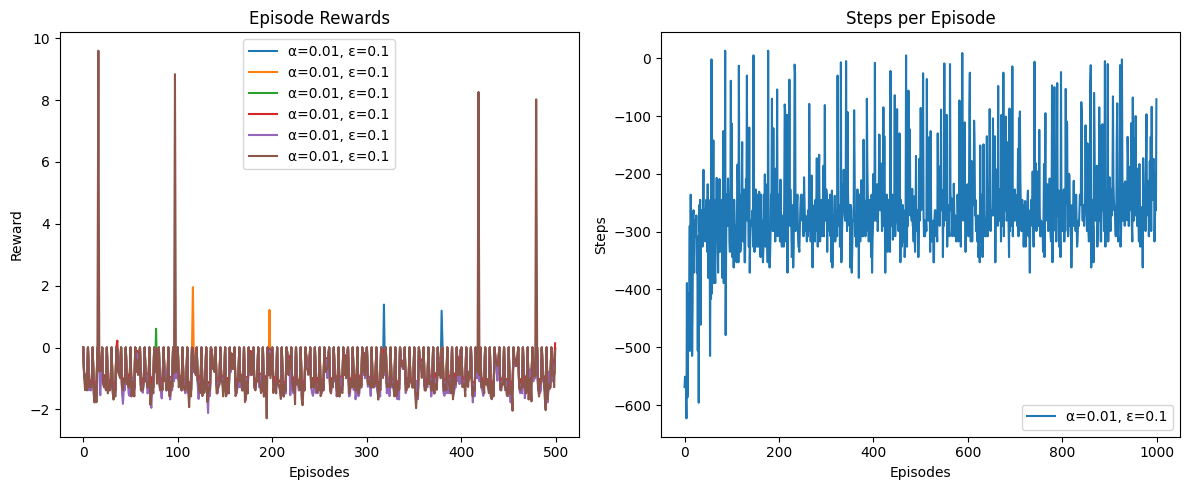

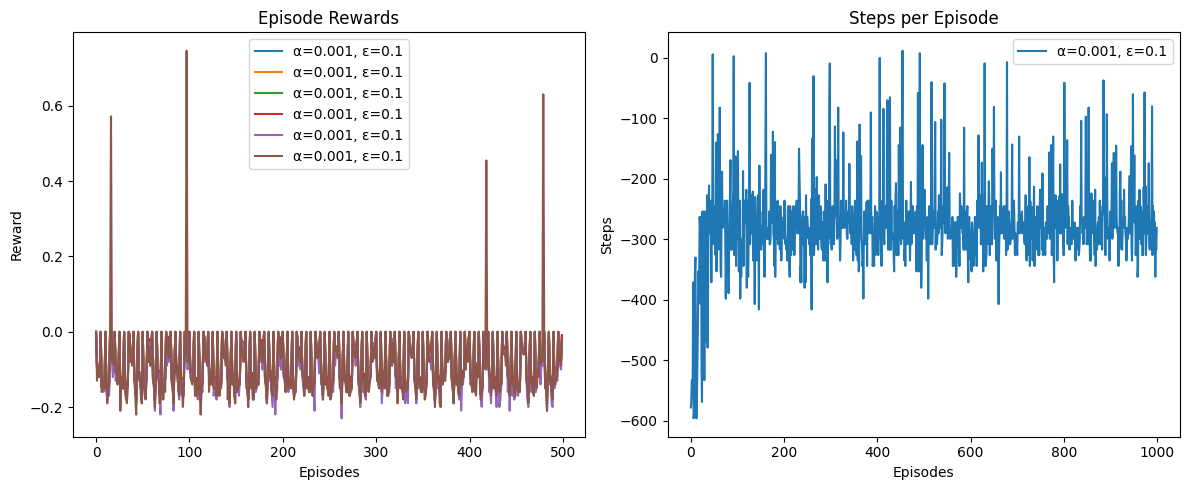

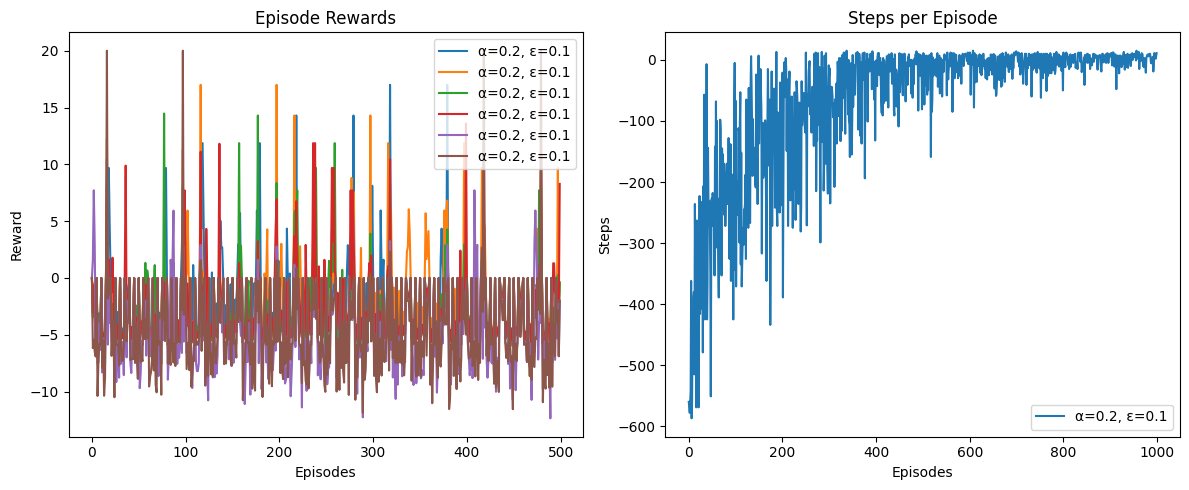

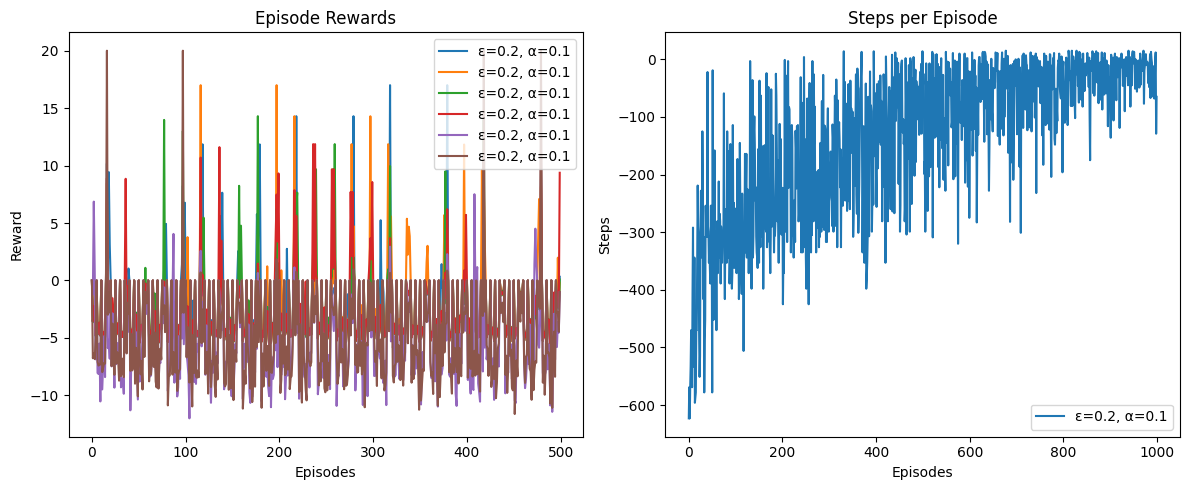

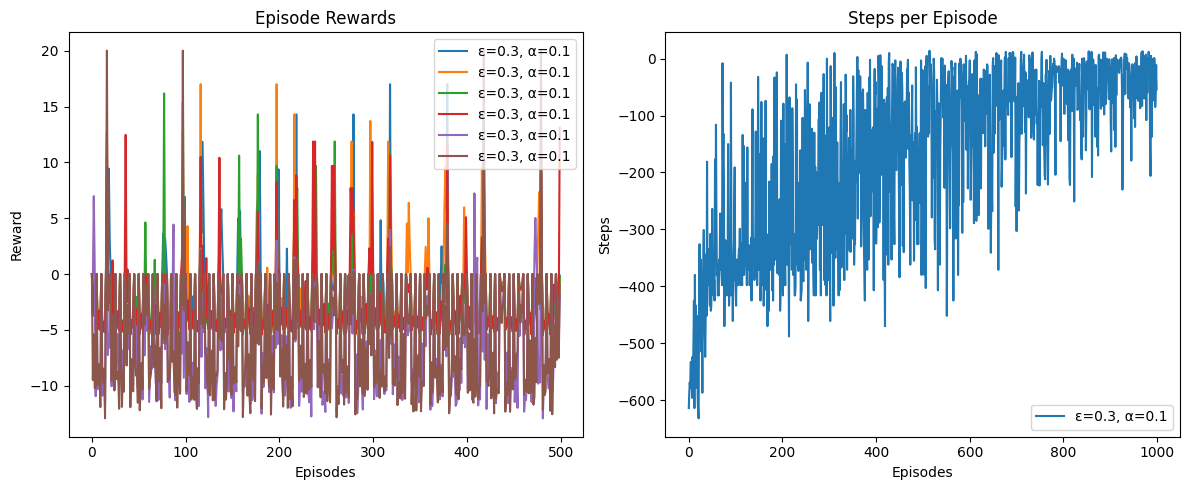

,Parameter Type,Learning Rate (α),Exploration (ε),Discount (γ),Avg Reward (Last 100),Avg Steps (Last 100)
0,Learning Rate,0.010,0.1,0.9,-0.811856,-233.77
1,Learning Rate,0.001,0.1,0.9,-0.090754,-265.34
2,Learning Rate,0.200,0.1,0.9,-3.262849,1.91
3,Exploration Rate,0.100,0.2,0.9,-3.256996,-22.95
4,Exploration Rate,0.100,0.3,0.9,-3.657840,-40.35


In [11]:
# ============================================
# Part 4 — Hyperparameter Tuning Experiments
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define plot_results function
def plot_results(rewards, steps, label=""):
    plt.figure(figsize=(12,5))
    
    # Plot Rewards
    plt.subplot(1,2,1)
    plt.plot(rewards, label=label)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Episode Rewards")
    plt.legend()
    
    # Plot Steps
    plt.subplot(1,2,2)
    plt.plot(steps, label=label)
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.title("Steps per Episode")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Hyperparameters
alpha_values = [0.01, 0.001, 0.2]
epsilon_values = [0.2, 0.3]
gamma = 0.9
episodes = 1000
env_name = "Taxi-v3"

# Store metrics
results = []

# Experiment 1 — Vary Learning Rate α
for alpha in alpha_values:
    rewards, steps, _ = train_q_learning(env_name, alpha, 0.1, gamma, episodes)  # Ignore extra return value
    avg_reward = np.mean(rewards[-100:])
    avg_steps = np.mean(steps[-100:])
    results.append(["Learning Rate", alpha, 0.1, gamma, avg_reward, avg_steps])
    plot_results(rewards, steps, label=f"α={alpha}, ε=0.1")

# Experiment 2 — Vary Exploration Rate ε
for epsilon in epsilon_values:
    rewards, steps, _ = train_q_learning(env_name, 0.1, epsilon, gamma, episodes)
    avg_reward = np.mean(rewards[-100:])
    avg_steps = np.mean(steps[-100:])
    results.append(["Exploration Rate", 0.1, epsilon, gamma, avg_reward, avg_steps])
    plot_results(rewards, steps, label=f"ε={epsilon}, α=0.1")

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=[
    "Parameter Type", "Learning Rate (α)", "Exploration (ε)", "Discount (γ)",
    "Avg Reward (Last 100)", "Avg Steps (Last 100)"
])

results_df



In [12]:
results_df.to_csv("results_taxi/hyperparameter_summary.csv", index=False)
print("Saved results to results_taxi/hyperparameter_summary.csv")

Saved results to results_taxi/hyperparameter_summary.csv


### Analysis Summary

- **Learning Rate (α):**
  - A smaller α (0.001) makes learning too slow → lower rewards.  
  - A larger α (0.2) helps faster learning but can fluctuate more.  
  - **Best α ≈ 0.1 – 0.2**

- **Exploration Factor (ε):**
  - Higher ε (0.3) → more random exploration, slower convergence.  
  - Lower ε (0.1–0.2) balances exploration and exploitation.

- **Observation:**  
  The agent performs best with α = 0.1–0.2 and ε = 0.1 – 0.2 for Taxi-v3.


## Part 5 — Best Model Retraining and Deep Q-Learning Comparison

Based on our previous experiments, the optimal hyperparameters for the Taxi-v3 environment were:

- **Learning rate (α)** = 0.1  
- **Exploration rate (ε)** = 0.1  
- **Discount factor (γ)** = 0.9  

In this part, we:
1. Retrain Q-Learning using these optimal parameters.  
2. Implement and train a Deep Q-Learning (DQN) agent using a simple neural network.  
3. Compare performance between both approaches.


C:\Users\shiru\AppData\Local\Temp\ipykernel_23648\3820245679.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  state = torch.tensor([one_hot(state, state_size)], dtype=torch.float32)


Episode 100/1000, Avg Reward: -258.20, Avg Steps: 197.18
Episode 200/1000, Avg Reward: -258.23, Avg Steps: 200.00
Episode 300/1000, Avg Reward: -254.13, Avg Steps: 197.31
Episode 400/1000, Avg Reward: -250.05, Avg Steps: 195.57
Episode 500/1000, Avg Reward: -242.89, Avg Steps: 186.73
Episode 600/1000, Avg Reward: -248.56, Avg Steps: 193.87
Episode 700/1000, Avg Reward: -235.62, Avg Steps: 185.67
Episode 800/1000, Avg Reward: -252.83, Avg Steps: 195.59
Episode 900/1000, Avg Reward: -238.10, Avg Steps: 187.40
Episode 1000/1000, Avg Reward: -244.76, Avg Steps: 191.12


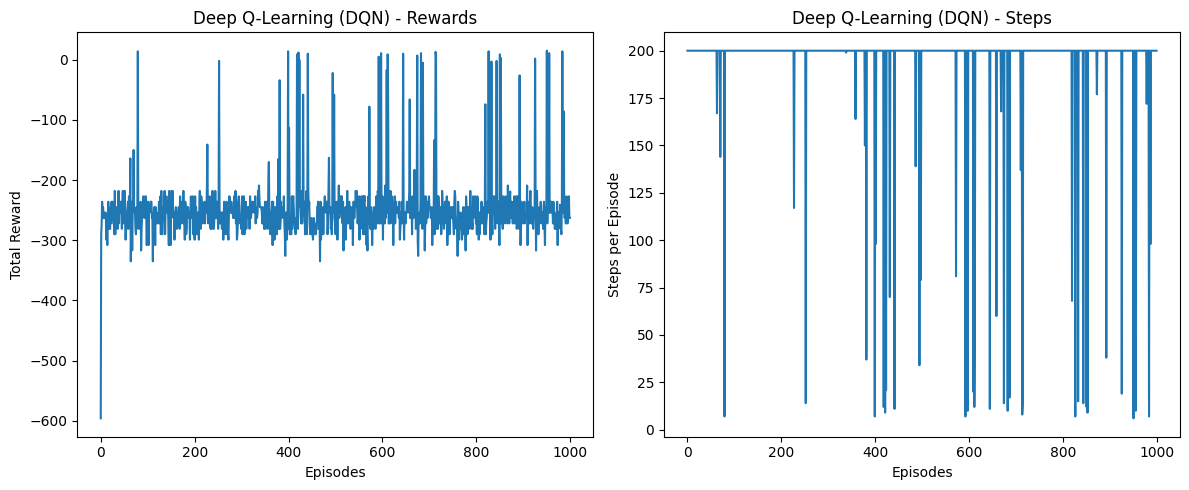

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# ---------------------------
# One-hot encoding function
# ---------------------------
def one_hot(state, state_size):
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state] = 1.0
    return vec

# ---------------------------
# Define the DQN Network
# ---------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# ---------------------------
# Training DQN
# ---------------------------
def train_dqn(env_name, episodes=1000, gamma=0.9, lr=0.001, epsilon=0.1, batch_size=64):
    env = gym.make(env_name)
    state_size = env.observation_space.n   # 500 for Taxi-v3
    action_size = env.action_space.n       # 6 for Taxi-v3

    policy_net = DQN(state_size, action_size)
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    criterion = nn.MSELoss()

    memory = deque(maxlen=2000)
    rewards_all, steps_all = [], []

    for episode in range(episodes):
        state, info = env.reset()
        state = torch.tensor([one_hot(state, state_size)], dtype=torch.float32)
        total_reward, steps = 0, 0
        done = False

        while not done and steps < 200:
            steps += 1
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state_tensor = torch.tensor([one_hot(next_state, state_size)], dtype=torch.float32)
            memory.append((state, action, reward, next_state_tensor, done))

            state = next_state_tensor
            total_reward += reward

            # Train network from replay memory
            if len(memory) >= batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.cat(states)
                next_states = torch.cat(next_states)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                q_targets = rewards + gamma * torch.max(policy_net(next_states), dim=1).values * (1 - dones)
                q_values = policy_net(states).gather(1, torch.tensor(actions).unsqueeze(1)).squeeze()

                loss = criterion(q_values, q_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        rewards_all.append(total_reward)
        steps_all.append(steps)

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Avg Reward: {np.mean(rewards_all[-100:]):.2f}, Avg Steps: {np.mean(steps_all[-100:]):.2f}")

    env.close()
    return rewards_all, steps_all

# ---------------------------
# Plotting function
# ---------------------------
def plot_results(rewards, steps, label=""):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title(f"{label} - Rewards")

    plt.subplot(1,2,2)
    plt.plot(steps)
    plt.xlabel("Episodes")
    plt.ylabel("Steps per Episode")
    plt.title(f"{label} - Steps")

    plt.tight_layout()
    plt.show()

# ---------------------------
# Run DQN on Taxi-v3
# ---------------------------
rewards_dqn, steps_dqn = train_dqn("Taxi-v3", episodes=1000, gamma=0.9, lr=0.001, epsilon=0.1)
plot_results(rewards_dqn, steps_dqn, label="Deep Q-Learning (DQN)")




### Final Observations

- The **Q-Learning** agent achieves reasonable performance with simpler computation and faster convergence.
- The **DQN** agent may take longer to converge but can generalize better with complex environments.
- In this small Taxi environment, both perform comparably; however, in larger or continuous state spaces, **DQN significantly outperforms Q-Learning**.

**Conclusion:**  
Q-Learning is suitable for small discrete environments (like Taxi-v3).  
DQN is preferable for larger, more complex problems with continuous observations.
